### Preparing data 
importing required libraries

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

In [94]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [95]:
merged_df = pd.merge(customers, transactions, on="CustomerID", how="inner")
merged_df

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64
...,...,...,...,...,...,...,...,...,...,...
995,C0200,Kelly Cross,Asia,2023-06-11,T00518,P034,2024-12-11 03:05:50,4,868.20,217.05
996,C0200,Kelly Cross,Asia,2023-06-11,T00091,P057,2024-04-27 19:06:20,1,239.70,239.70
997,C0200,Kelly Cross,Asia,2023-06-11,T00731,P061,2024-07-15 20:36:28,4,627.84,156.96
998,C0200,Kelly Cross,Asia,2023-06-11,T00771,P048,2024-09-10 09:50:48,4,1665.60,416.40


In [96]:
# Checking for missing values in the merged dataset
merged_df.isnull().sum()

CustomerID         0
CustomerName       0
Region             0
SignupDate         0
TransactionID      0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64

##### Identifying outliers using z-score

In [97]:
# List of numerical columns to check for outliers and calculating z-scores of these cols 
numerical_columns = ['Quantity', 'TotalValue', 'Price']
z_scores = stats.zscore(merged_df[numerical_columns])

# removing outliers from the merged data
merged_df_no_outliers = merged_df[(z_scores < 3).all(axis=1)] 


# Checking the shape of the dataset before and after removing outliers
print(f"Original shape: {merged_df.shape}")
print(f"Shape after removing outliers: {merged_df_no_outliers.shape}")


Original shape: (1000, 10)
Shape after removing outliers: (1000, 10)


##### calculating transaction-based features

In [98]:
transaction_features = transactions.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    transaction_frequency=('TransactionDate', 'nunique')
).reset_index()

print(transaction_features.head())
# Merge the transaction features with customer profile data
final_df = pd.merge(merged_df_no_outliers, transaction_features, on='CustomerID', how='inner')

# Checking the final dataframe
final_df.head()

  CustomerID  total_spend  num_transactions  avg_transaction_value  \
0      C0001      3354.52                 5                670.904   
1      C0002      1862.74                 4                465.685   
2      C0003      2725.38                 4                681.345   
3      C0004      5354.88                 8                669.360   
4      C0005      2034.24                 3                678.080   

   transaction_frequency  
0                      5  
1                      4  
2                      4  
3                      8  
4                      3  


,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price,total_spend,num_transactions,avg_transaction_value,transaction_frequency
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30,3354.52,5,670.904,5
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54,3354.52,5,670.904,5
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47,3354.52,5,670.904,5
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72,3354.52,5,670.904,5
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64,3354.52,5,670.904,5


#### Clustering

In [99]:
db_indexes = []

In [79]:
# Selecting features to use for clustering (customer segmentation)
clustering_data = final_df.drop(columns=['CustomerID', 'CustomerName', 'SignupDate', 'TransactionID', 'ProductID', 'TransactionDate', 'Region'])
clustering_data

,Quantity,TotalValue,Price,total_spend,num_transactions,avg_transaction_value,transaction_frequency
0,2,114.60,57.30,3354.52,5,670.904,5
1,3,412.62,137.54,3354.52,5,670.904,5
2,2,614.94,307.47,3354.52,5,670.904,5
3,2,911.44,455.72,3354.52,5,670.904,5
4,3,1300.92,433.64,3354.52,5,670.904,5
...,...,...,...,...,...,...,...
995,4,868.20,217.05,4758.60,5,951.720,5
996,1,239.70,239.70,4758.60,5,951.720,5
997,4,627.84,156.96,4758.60,5,951.720,5
998,4,1665.60,416.40,4758.60,5,951.720,5


In [100]:
# Number of clusters
n_clusters = range(2, 11)

# clustering with KMeans for each number of clusters

for c in n_clusters:
    kmeans = KMeans(n_clusters=c, random_state=42)
    clusters = kmeans.fit_predict(clustering_data)
    
    # Calculate DB Index for current clustering
    db_index = davies_bouldin_score(clustering_data, clusters)
    db_indexes.append(db_index)
    
    print(f"DB Index for {n_clusters} clusters: {db_index}")

# optimal cluster number
optimal_cluster = n_clusters[np.argmin(db_indexes)]
print(f"Optimal number of clusters: {optimal_cluster}")

# optimal db index
print(f"Optimal DB Index: {min(db_indexes)}")


DB Index for range(2, 11) clusters: 0.6666983068858876
DB Index for range(2, 11) clusters: 0.806973040543853
DB Index for range(2, 11) clusters: 0.6862850070965182
DB Index for range(2, 11) clusters: 0.7691137768214633
DB Index for range(2, 11) clusters: 0.8178674788300784
DB Index for range(2, 11) clusters: 0.8535930488710434
DB Index for range(2, 11) clusters: 0.870370658043726
DB Index for range(2, 11) clusters: 0.87112368697512
DB Index for range(2, 11) clusters: 0.9144673849108145
Optimal number of clusters: 2
Optimal DB Index: 0.6666983068858876


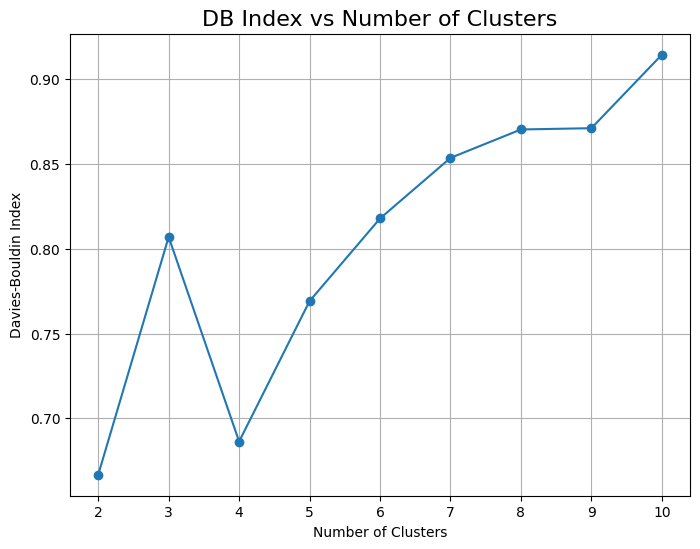

In [101]:
# Plotting DB Index vs Number of Clusters
plt.figure(figsize=(8, 6))
plt.plot(n_clusters, db_indexes, marker='o', linestyle='-')
plt.title('DB Index vs Number of Clusters', fontsize=16)
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(n_clusters)
plt.grid(True)
plt.show()

 Performing PCA reducing the dimensionality of the data to 2 principal components for visualization

In [102]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(clustering_data)

##### Performing K-Means clustering with 2 clusters (based on the DB Index result)
2 clusters seems to be the best choice based on the DB Index because it has the lowest value (0.6666983068858876).


In [103]:
kmeans = KMeans(n_clusters=optimal_cluster, random_state=42)
clusters = kmeans.fit_predict(clustering_data)

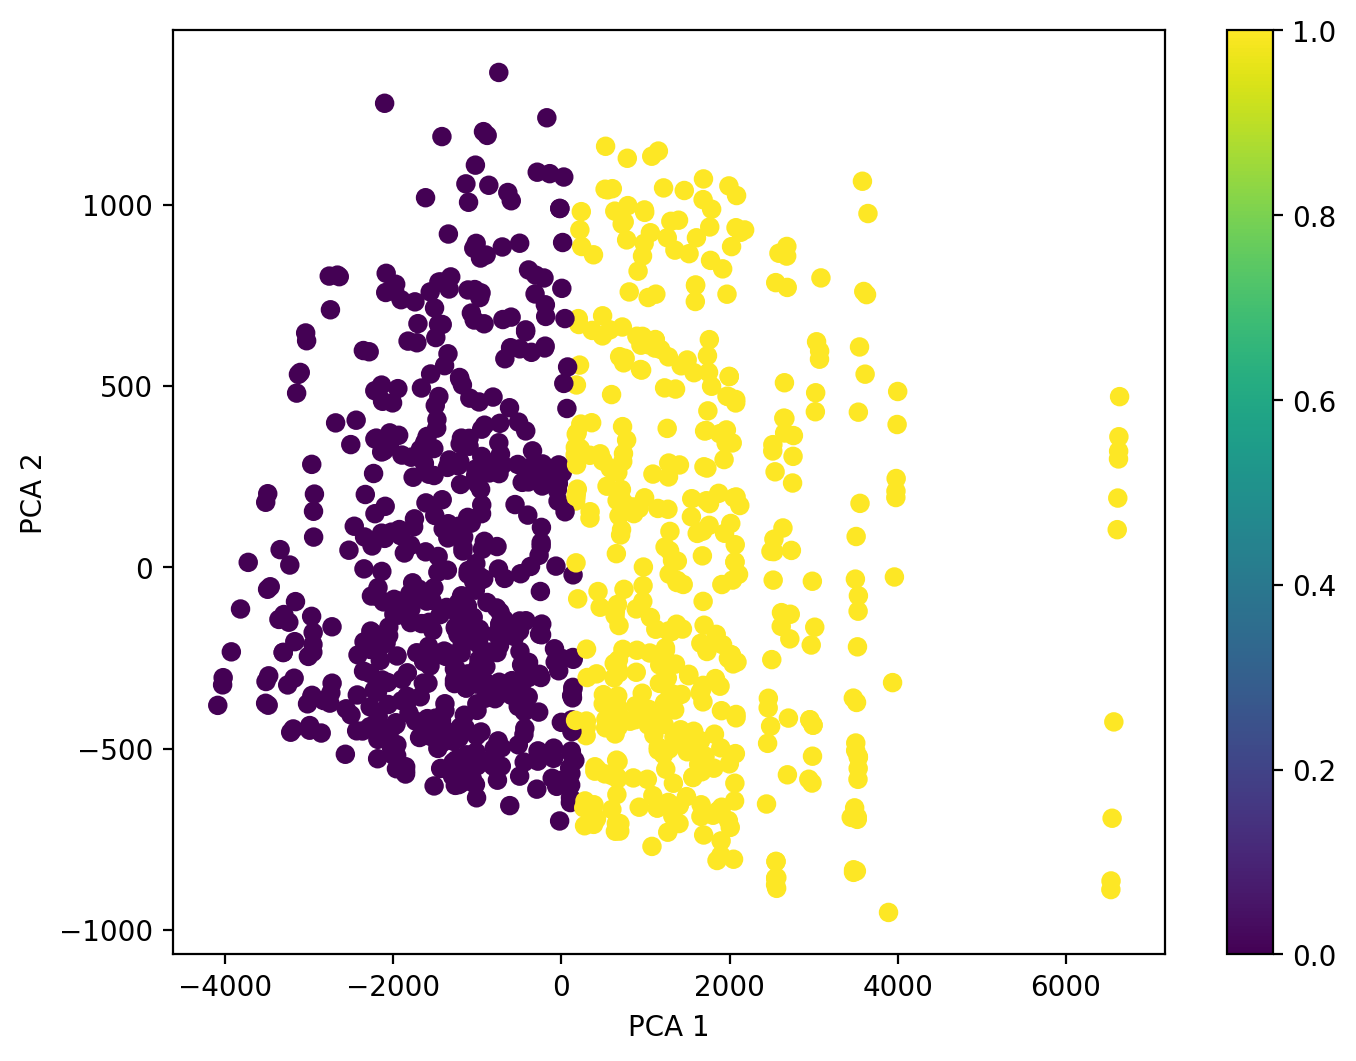

In [104]:
plt.figure(figsize=(8, 6), dpi=200)
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=clusters)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar()
plt.show()

In [105]:

# Perform Clustering with the optimal number of clusters
optimal_k = optimal_cluster 
kmeans = KMeans(n_clusters=optimal_cluster, random_state=42)
optimal_clstrs = kmeans.fit_predict(clustering_data)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(clustering_data, optimal_clstrs)
print(f"Silhouette Score for k={optimal_cluster}: {silhouette_avg}")

# Add cluster labels to the DataFrame
final_df['Cluster'] = optimal_clstrs

# Create Cluster Profiles
cluster_profiles = final_df.groupby('Cluster').agg(
    avg_transaction_value=('avg_transaction_value', 'mean'),
    total_spend=('total_spend', 'mean'),
    num_transactions=('num_transactions', 'mean'),
    transaction_frequency=('transaction_frequency', 'mean')
).reset_index()

print(cluster_profiles)

# Save the results to CSV
final_df.to_csv('Clustered_Customers.csv', index=False)
cluster_profiles.to_csv('Cluster_Profiles.csv', index=False)
final_df.head()

Silhouette Score for k=2: 0.5228035347189961
   Cluster  avg_transaction_value  total_spend  num_transactions  \
0        0             593.966673  2761.883195          4.882671   
1        1             809.278079  5764.998274          7.347534   

   transaction_frequency  
0               4.882671  
1               7.347534  


,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price,total_spend,num_transactions,avg_transaction_value,transaction_frequency,Cluster
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30,3354.52,5,670.904,5,0
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54,3354.52,5,670.904,5,0
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47,3354.52,5,670.904,5,0
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72,3354.52,5,670.904,5,0
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64,3354.52,5,670.904,5,0
